In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('C:/Users/ASUS-PC/Desktop/.../Storage/es-1min_FULL.csv')
data

,date,time,open,high,low,close
0,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
1,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
3,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
4,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
390547,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
390548,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
390549,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
390550,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


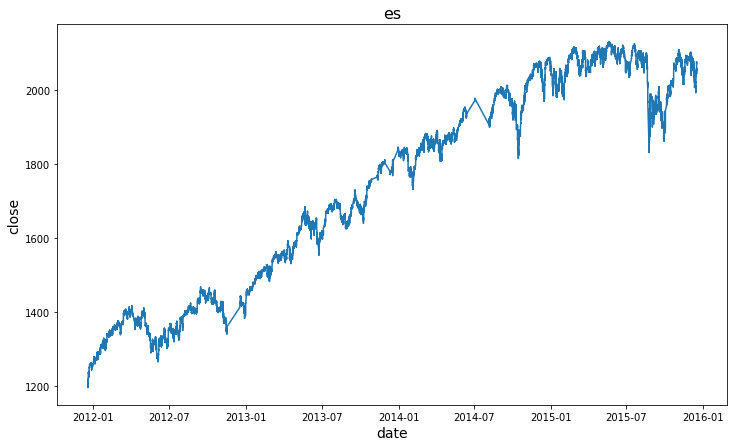

In [3]:
import datetime as dt

y = data['close'].values
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in data['date'].values]

fig, ax = plt.subplots(figsize = (12, 7))
plt.plot(x,y)
plt.ylabel('close', fontsize = 14)
plt.xlabel('date', fontsize = 14)
plt.title('es', fontsize = 16)
plt.show()

In [4]:
def VR(q : int, P) -> float:
    X = np.log(P)
    nq = X.shape[0] - 1

    mu = 1 / nq * (X[nq] - X[0])
    sigma1 = 1 / (nq - 1) * np.sum([(X[i] - X[i - 1] - mu) ** 2 for i in range(1, nq + 1)])
    m = q * (nq - q + 1) * (1 - q / nq)
    sigma_q = 1 / m * np.sum([(X[i] - X[i - q] - q * mu) ** 2 for i in range(q, nq + 1)])

    return sigma_q / sigma1

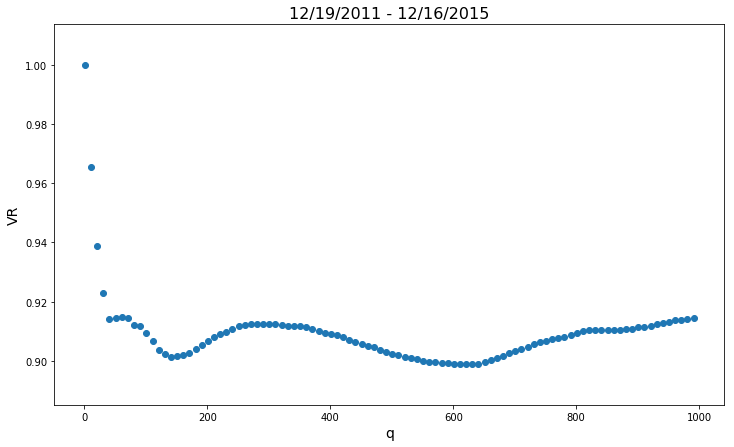

In [5]:
xi = np.arange(1, 1000, 10)
yi = np.array([VR(q, data['close'].values) for q in xi])

fig, ax = plt.subplots(figsize = (12, 7))
plt.scatter(xi, yi)
plt.ylabel('VR', fontsize = 14)
plt.xlabel('q', fontsize = 14)
plt.title(str(data['date'].values[0]) + ' - ' + str(data['date'].values[len(data) - 1]), fontsize=16)
plt.show()

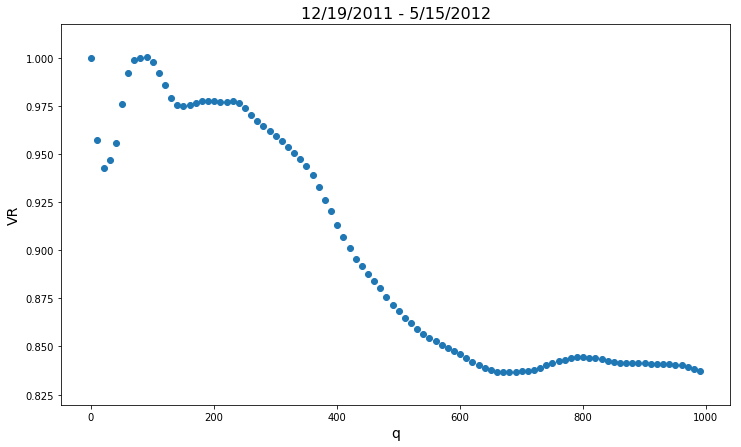

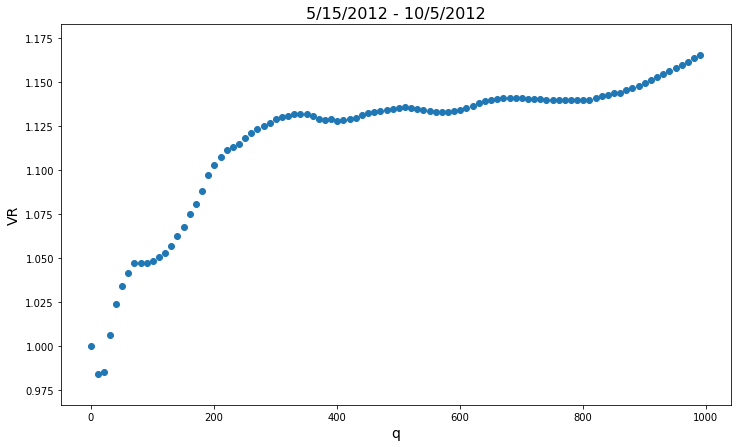

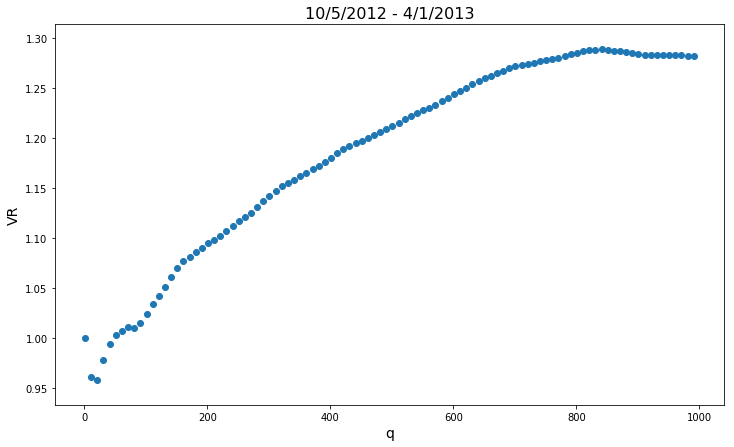

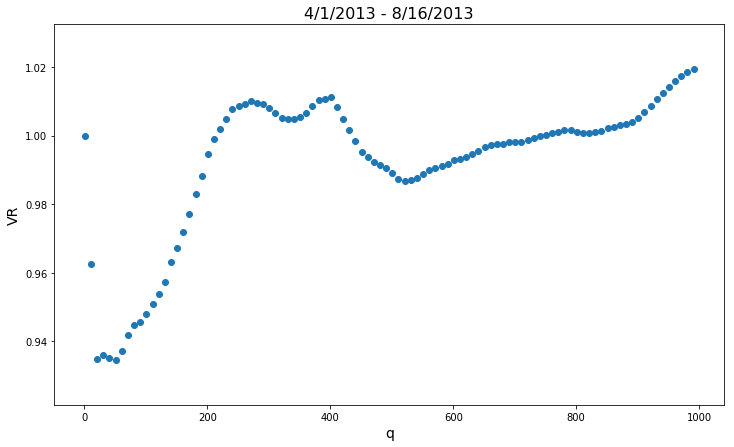

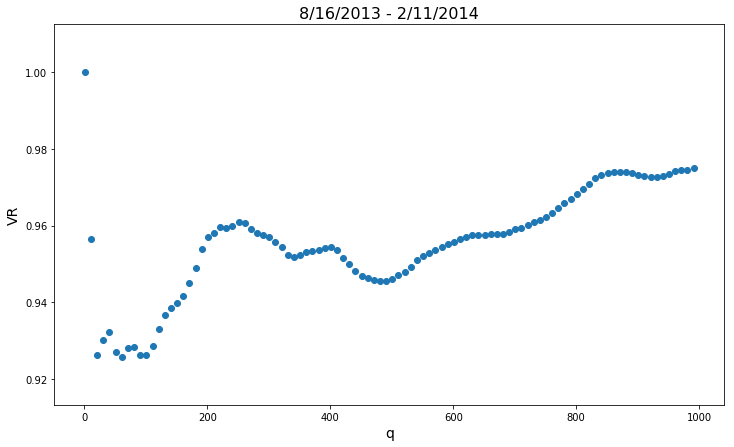

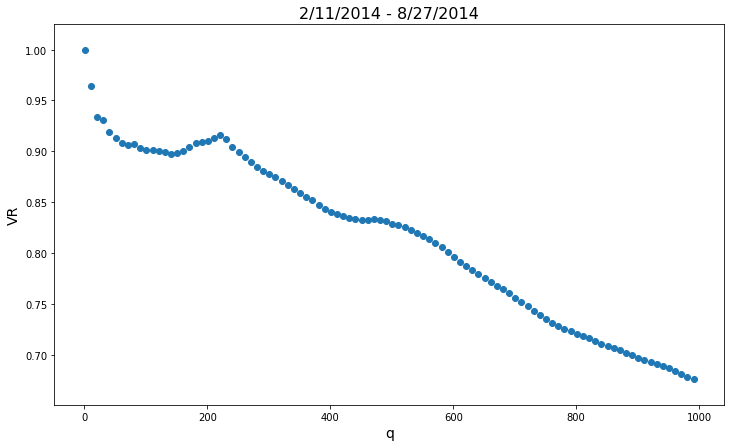

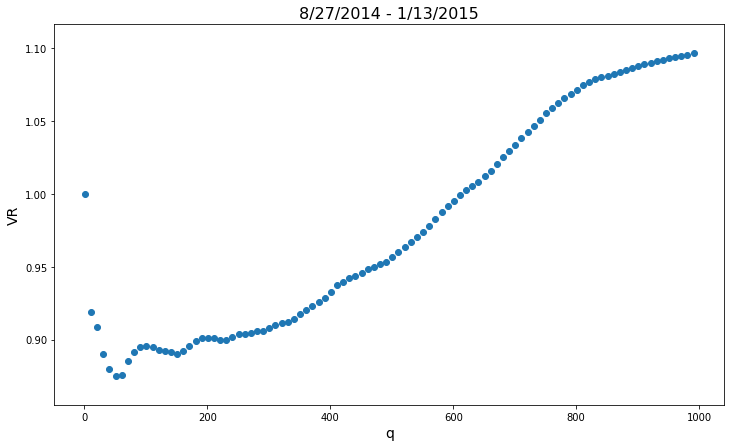

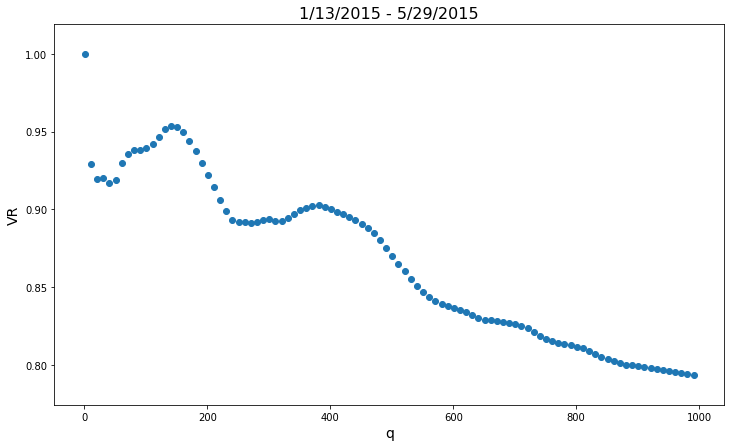

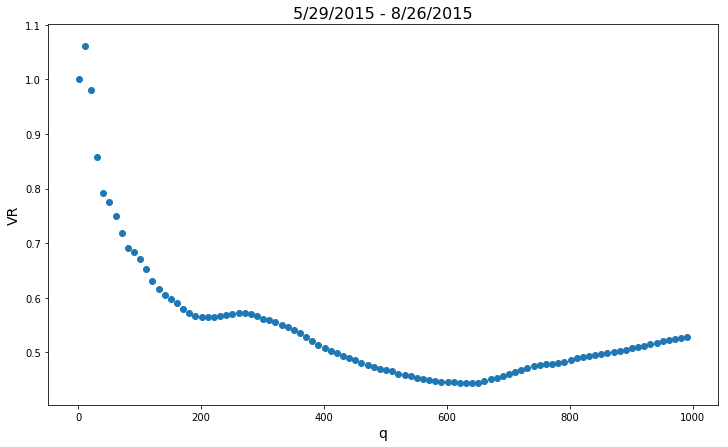

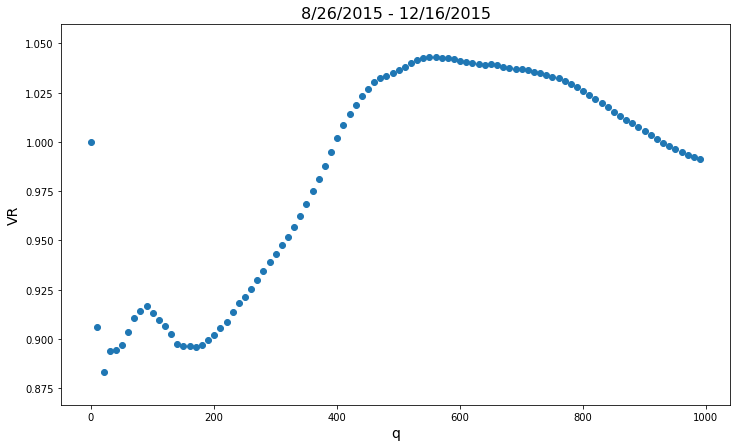

In [18]:
amount = 10
window = len(data) // amount
for num in range(amount):
    xi = np.arange(1, 1000, 10)
    yi = np.array([VR(q, data['close'].values[num * window : (num + 1) * window]) for q in xi])

    fig, ax = plt.subplots(figsize = (12, 7))
    plt.scatter(xi, yi)
    plt.ylabel('VR', fontsize = 14)
    plt.xlabel('q', fontsize = 14)
    plt.title(str(data['date'].values[num * window]) + ' - ' + str(data['date'].values[(num + 1) * window - 1]), fontsize=16)
    plt.show()

In [41]:
# https://mingze-gao.com/measures/lomackinlay1988/

def _estimate(log_prices, k, const_arr):
    # Log returns = [x2, x3, x4, ..., xT], where x(i)=ln[p(i)/p(i-1)]
    rets = np.diff(log_prices)
    # T is the length of return series
    T = len(rets)
    # mu is the mean log return
    mu = np.mean(rets)
    # sqr_demeaned_x is the array of squared demeaned log returns
    sqr_demeaned_x = np.square(rets - mu)
    # Var(1)
    # Didn't use np.var(rets, ddof=1) because
    # sqr_demeaned_x is calculated already and will be used many times.
    var_1 = np.sum(sqr_demeaned_x) / (T-1)
    # Var(k)
    # Variance of log returns where x(i) = ln[p(i)/p(i-k)]
    # Before np.roll() - array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    # After np.roll(,shift=2) - array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])
    # Discard the first k elements.
    rets_k = (log_prices - np.roll(log_prices, k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    # Variance Ratio
    vr = var_k / var_1

    # a_arr is an array of { (2*(k-j)/k)^2 } for j=1,2,...,k-1, fixed for a given k:
    #   When k=5, a_arr = array([2.56, 1.44, 0.64, 0.16]).
    #   When k=8, a_arr = array([3.0625, 2.25, 1.5625, 1., 0.5625, 0.25, 0.0625])
    # Without JIT it's defined as:
    #   a_arr = np.square(np.arange(k-1, 0, step=-1, dtype=np.int) * 2 / k)
    # But np.array creation is not allowed in nopython mode.
    # So const_arr=np.arange(k-1, 0, step=-1, dtype=np.int) is created outside.
    a_arr = np.square(const_arr * 2 / k)

    # b_arr is part of the delta_arr.
    b_arr = np.empty(k-1, dtype=np.float64)
    for j in range(1, k):
        b_arr[j-1] = np.sum((sqr_demeaned_x *
                             np.roll(sqr_demeaned_x, j))[j+1:])

    delta_arr = b_arr / np.square(np.sum(sqr_demeaned_x))

    # Both arrarys are of length (k-1)
    assert len(delta_arr) == len(a_arr) == k-1

    phi1 = 2 * (2*k - 1) * (k-1) / (3*k*T)
    phi2 = np.sum(a_arr * delta_arr)

    # VR test statistics under two assumptions
    vr_stat_homoscedasticity = (vr - 1) / np.sqrt(phi1)
    vr_stat_heteroscedasticity = (vr - 1) / np.sqrt(phi2)

    return vr, vr_stat_homoscedasticity, vr_stat_heteroscedasticity


def estimate(data):
    "A fast estimation of Variance Ratio test statistics as in Lo and MacKinlay (1988)"
    # Prices array = [p1, p2, p3, p4, ..., pT]
    prices = data['close'].to_numpy(dtype=np.float64)
    result = []
    # Estimate many lags.
    for k in [2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 100, 200, 500, 1000]:
        # Compute a constant array as np.array creation is not allowed in nopython mode.
        const_arr = np.arange(k-1, 0, step=-1, dtype=np.int)
        vr, stat1, stat2 = _estimate(np.log(prices), k, const_arr)
        result.append({
            f'Variance Ratio (k={k})': vr,
            f'Variance Ratio Test Statistic (k={k}) Homoscedasticity Assumption': stat1,
            f'Variance Ratio Test Statistic (k={k}) Heteroscedasticity Assumption': stat2
        })
    return result